63f78014766fd30436c18a79_Hyperspace - navbar logo.png

#  Binary Vector and Metadata Search with Hyperspace
This notebook demonstrates the use of Hyperspace engine for a hybrid search that combines vector search of binary vectors and metadata filtering over their corresponding metadata.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hyper-space-io/QuickStart/blob/master/DataSets/BinaryVector/Binary_Vector_Search.ipynb)
# Hyperspace Hybrid search
This notenook combines approximate KNN (using IVF approximation) with metadata filtering. In this scheme, Hyperspace uses the post-filtering approach, by which the ANN matching is first perfomed, followed by metadata filtering.

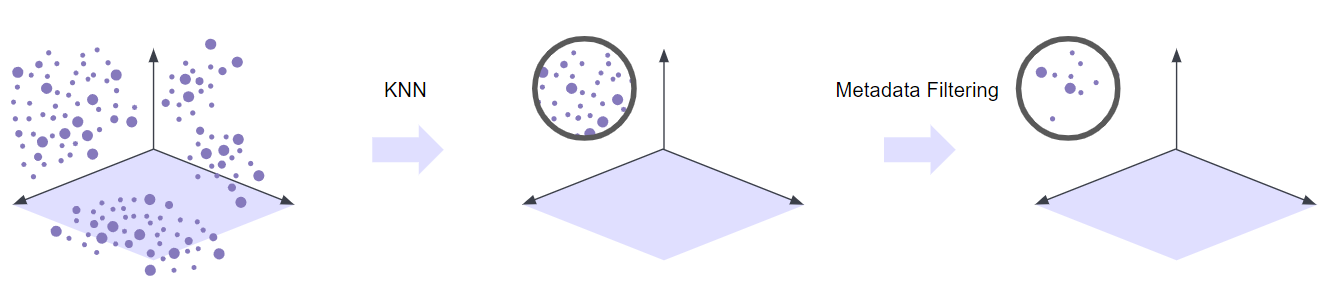

This approach optimizes the query recall, at the expanse of latency, as applying the filtering first may cause the data graph to become sparse and omit relevant results from the search.
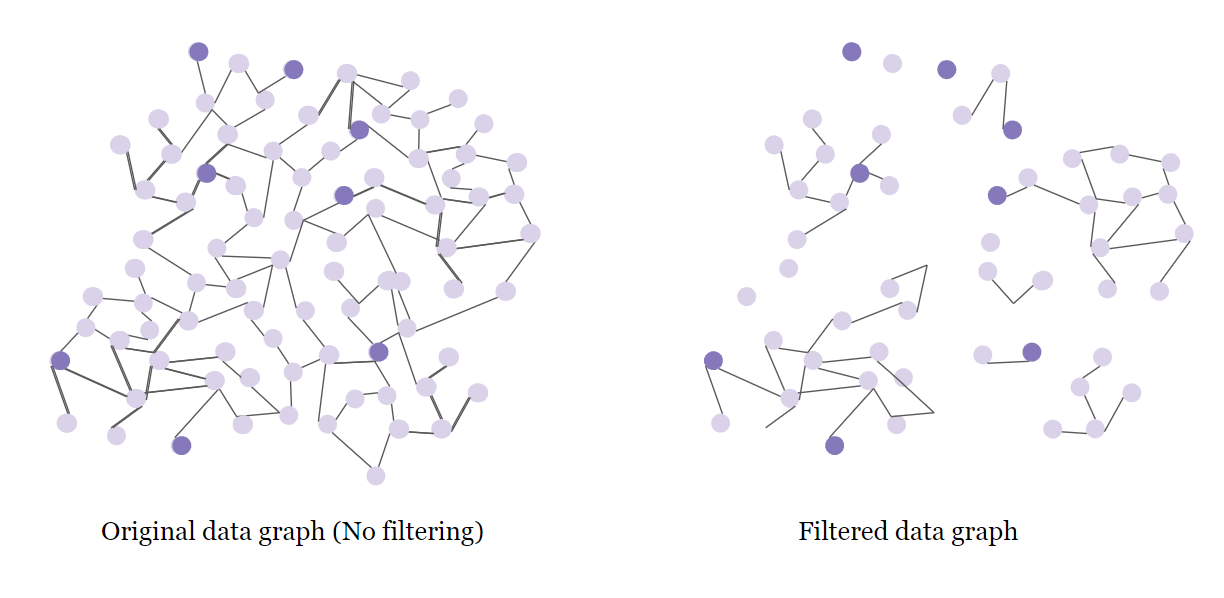


# The Dataset
The dataset includes randomly generated binary vectors of dimension 800 and corresponding metadata, that describes stores for a recommednation engine.

## The Dataset Fields
The metadata can be downloaded from [here](https://github.com/hyper-space-io/QuickStart/blob/main/DataSets/BinaryVector/Generated_data.hsv) includes the following fields:
1. **country** [string] - The Country in which the store is located
2. **city** [string] - The city in which the store is located
3. **street** [keyword] - The street in which the store is located
4. **zip_code** [integer] - The store zipcode
5. **open_now** [boolean] - Is the store open
6. **vertical** [keyword] - The store vertical (industry)

# Setting up the Hyperspace Environment
Setting the environment and running the query includes the following steps

1. Download and install the client API
2. Connect to a server
3. Create data schema file
4. Create collection
5. Ingest data
6. Define Logic and Run a Query

## 1. Install the Hyperspace client API
Hyperspace API can be installed directly from git, using the following command:

In [3]:
pip install hyperspace-py

  Cloning https://github.com/hyper-space-io/hyperspace-py to c:\users\tamirbracha\appdata\local\temp\pip-req-build-5xyh181q
  Resolved https://github.com/hyper-space-io/hyperspace-py to commit c49c83710c5b466a4bb299f7ad70f618d3a6df94
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/hyper-space-io/hyperspace-py 'C:\Users\TamirBracha\AppData\Local\Temp\pip-req-build-5xyh181q'
DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


## 2. Connect to a server

Once the Hyperspace API is installed, the database can be accessed by creating a local instance of the Hyperspace client. This step requires host address, username and password.

In [4]:
import hyperspace
from getpass import getpass

username = "USERNAME"
host = "HOST_URL"

hyperspace_client = hyperspace.HyperspaceClientApi(host=host, username=username, password=getpass())

Before continuing, let us check that the cluster is live

In [5]:
collections_info = hyperspace_client.collections_info()
display(collections_info)

{'collections': {'all-MiniLM-L6-v2_arXiv': {'creation_time': '2024-01-01T19:23:25Z',
   'last_query_time': '2024-01-01T19:25:41Z',
   'size': 100001}}}

## 3.  Create a Data Schema File

Similarly to other search databases, Hyper-Space database requires a configuration file that outlines the data schema. Here, we create a config file that corresponds to the fields of the given dataset.

For vector fields, we also provide the index type to be used, and the metric. . Current options for index include "**brute_force**", "**hnsw**", "**ivf**", and "**bin_ivf**" for binary vectors, and "**IP**" (inner product) as a metric for floating point vectors and "**Hamming**" ([hamming distance](https://en.wikipedia.org/wiki/Hamming_distance)) for binary vectors.
Note that the key 'low_cardinality' enables faster search for low cardinality fields.

In [6]:
import json
vector_dimension = 800 # bits
config = {
    "configuration": {
        "id": {
          "type": "keyword",
          "id": True
        },
        'city': {"type": 'keyword'},
        'country': {"type": 'keyword'},
        'open_now': {"type": 'boolean'},
        'zip_code': {"type": 'integer'},
        'street': {"type": 'keyword'},
        'vertical': {"type": 'keyword', 'low_cardinality': True},
        "vector": {
            "type": "dense_vector",
            "index_type": "bin_ivf",
            "dim": vector_dimension,
            "metric": "hamming"
        }
    }
}

with open('config.json', 'w') as f:
    f.write(json.dumps(config, indent=2))


## 4. Create Collection
The Hyerspace engine stroes data in Collections, where each collecction commonly hosts data of similar context, etc. Each search is then perfomed within a collection. We create a collection using the command "**create_collection**(schema_filename, collection_name)".

In [7]:
collection_name = 'GeneratedData'

if collection_name not in hyperspace_client.collections_info()["collections"]:
  hyperspace_client.create_collection('config.json', collection_name)

hyperspace_client.collections_info()

{'collections': {'GeneratedData': {'creation_time': '2024-01-01T19:34:22Z',
   'size': 0},
  'all-MiniLM-L6-v2_arXiv': {'creation_time': '2024-01-01T19:23:25Z',
   'last_query_time': '2024-01-01T19:25:41Z',
   'size': 100001}}}

# 5. Ingest data

In the next step we ingest the dataset in batches of 250 documents. This number can be controlled by user, and in particular, can be increased in order improve ingestion time. We add batches of data using the command **add_batch**(batch, collection_name).

In [8]:
import random
import secrets
import base64

def generate_data(metadata, vector_dimension):
    data_point = random.choice(metadata)
    random_bytes = secrets.token_bytes(vector_dimension // 8)
    data_point['vector'] =  base64.b64encode(random_bytes).decode()
    return data_point

In [9]:
import pickle

data_path = 'Generated_data.hsv'
with open(data_path, 'rb') as file:
  metadata = pickle.load(file)

BATCH_SIZE = 250

batch = []
data = []


for i, vec in enumerate(range(100000)):
    data_point = generate_data(metadata, vector_dimension)
    data_point["id"] = str(i)
    batch.append(dict(data_point))

    if (i+1) % BATCH_SIZE == 0:
        response = hyperspace_client.add_batch(batch, collection_name)
        print(i + 1, response)
        batch.clear()

if batch:
    hyperspace_client.add_batch(batch, collection_name)
    response = hyperspace_client.add_batch(batch, collection_name)

hyperspace_client.commit(collection_name)



250 {'code': 200, 'message': 'Batch successfully added', 'status': 'OK'}
500 {'code': 200, 'message': 'Batch successfully added', 'status': 'OK'}
750 {'code': 200, 'message': 'Batch successfully added', 'status': 'OK'}
1000 {'code': 200, 'message': 'Batch successfully added', 'status': 'OK'}
1250 {'code': 200, 'message': 'Batch successfully added', 'status': 'OK'}
1500 {'code': 200, 'message': 'Batch successfully added', 'status': 'OK'}
1750 {'code': 200, 'message': 'Batch successfully added', 'status': 'OK'}
2000 {'code': 200, 'message': 'Batch successfully added', 'status': 'OK'}
2250 {'code': 200, 'message': 'Batch successfully added', 'status': 'OK'}
2500 {'code': 200, 'message': 'Batch successfully added', 'status': 'OK'}
2750 {'code': 200, 'message': 'Batch successfully added', 'status': 'OK'}
3000 {'code': 200, 'message': 'Batch successfully added', 'status': 'OK'}
3250 {'code': 200, 'message': 'Batch successfully added', 'status': 'OK'}
3500 {'code': 200, 'message': 'Batch succ

{'code': 200, 'message': 'Dataset committed successfully', 'status': 'OK'}

#6. Define Logic and Run a Query
We will build a hybrid search query using Hyper-space. In the query,  we will select a document and find similar ones. We must first compile the score function using the "set_function" command.

In [10]:
import inspect

def set_score_function(func, collection_name, score_function_name='func'):
    source = inspect.getsource(func)
    with open('sf.py', 'w') as f:
        f.write(source)
    hyperspace_client.set_function('sf.py', collection_name, score_function_name)


In [11]:
def similarity_score(params, doc):
  score = 0.0
  if match("country"):
    score = 5.0
    if match("street"):
      score = 10.0
  return score

set_score_function(similarity_score, collection_name, score_function_name='similarity_score')

The next step is to retrieve a document and perform simialrity search.

In [12]:
input_document = hyperspace_client.get_document(collection_name, 65)
input_document

{'city': 'North Andrew',
 'country': 'Croatia',
 'open_now': False,
 'zip_code': 92543,
 'vector': 'X5gYG7oS8VMDBzhYHRhtqIEylHrh/II+tXpBVtZFPotal7gRAq2++M1Bf5MgtxD3ebghfg1SD9H8IMWrVhJXnBr/kGx3pINOOjewX6Ei+yUB40fUx9QSA6aSMmHGt63svrzY0Q==',
 'id': '65'}

# Vector Search

In [13]:
import random
from pprint import pprint


query_with_knn = {
    'params': input_document,
     "query": {"boost": 0},
    'vector':{"boost": 10}
}

results = hyperspace_client.search(query_with_knn,
                                        size=15,
                                        collection_name=collection_name)
candidates = results['candidates']

print(f"Query run time: {results['took_ms']:.2f}ms")
pprint(results['similarity'])


Query run time: 2.00ms
[{'document_id': '17462', 'score': 356.0},
 {'document_id': '99138', 'score': 356.0},
 {'document_id': '35344', 'score': 355.0},
 {'document_id': '74306', 'score': 355.0},
 {'document_id': '96339', 'score': 355.0},
 {'document_id': '99973', 'score': 355.0},
 {'document_id': '43130', 'score': 354.0},
 {'document_id': '97431', 'score': 354.0},
 {'document_id': '44183', 'score': 353.0},
 {'document_id': '17057', 'score': 351.0},
 {'document_id': '37998', 'score': 349.0},
 {'document_id': '88328', 'score': 349.0},
 {'document_id': '68018', 'score': 347.0},
 {'document_id': '76859', 'score': 346.0},
 {'document_id': '65', 'score': 0.0}]


# Results
The results are sorted by Hamming distance, as expected.

In [14]:
for i, x in enumerate(results['similarity']):
  document = hyperspace_client.get_document(collection_name, x["document_id"])
  print(i, document)

0 {'city': 'South Steven', 'country': 'Honduras', 'open_now': True, 'zip_code': 58113, 'vertical': 'jungle', 'vector': 'XV1vmYSScRUYB5qk/i3y4TBwLiD1vZUcpxv6ZFluLKVXL3hrqWruMf7C3jn16Havay2JHFOLbCWscma0Y32jeIMWKWRjRxsMDjsQL2sig9QFhmD6kh+oEqWy8NbUNCF1eUq2lw==', 'id': '17462'}
1 {'city': 'Robertview', 'country': 'Zambia', 'open_now': False, 'zip_code': 81403, 'vector': 'zJgBmeiToUsRCigTjQsFO9ixMjcg0QXYp9IX+bJJjQHnTjRSTEYXgDR9z6PUlDeTT6eRdihEGo0im3TLAiKI6YqrGLPysb1KQR+poSiKOmwxwiiKW/XQnGSH9BWPM88pj0ZmXA==', 'id': '99138'}
2 {'city': 'East Tracy', 'country': 'Belgium', 'open_now': False, 'zip_code': 64267, 'vertical': 'noodle', 'vector': 'W0HW2kU6OMmKl7RxZTjmqaN1Fq4l1u3l1J4sZqoovp2JDLrZSnrK/b8hO3BX5iOBE6ANYpowNAIkcfOtW5SPRw6TB3LjqQI+fBJT85hTkycl4PNH0BrK7trqUgLKqJRiopocuQ==', 'id': '35344'}
3 {'city': 'New Emilystad', 'country': 'Jersey', 'open_now': False, 'zip_code': 10183, 'street': 'zebra', 'vector': 'zSgcO42N0RcabLDbH36NesI1SSqYpOWGaiEbB/UhiUR6nm1On/g4OqrZL66hB25yWtT9ag5GCpHNTbiGuT4tjA9P

#Hybrid Search

In [15]:
import random
from pprint import pprint


query_with_knn = {
    'params': input_document,
     "query": {"boost": 0},
    'vector':{"boost": 10}
}

results = hyperspace_client.search(query_with_knn,
                                        size=15,
                                        function_name='similarity_score',
                                        collection_name=collection_name)
candidates = results['candidates']

print(f"Query run time: {results['took_ms']:.2f}ms")
pprint(results['similarity'])


Query run time: 2.43ms
[{'document_id': '65', 'score': 5.0}]


This notebook gave a simple example of the use of the Hyperspace engine for hybrid search. Hyperspace can support signficantly more complicated use cases with large databases, in extremley low latency.